# Original CNN Model
By Prof Andrew

### Step 3: Split to train/test 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score,f1_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPool2D, InputLayer, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
import keras
import tensorflow as tf
import pickle

output_prefix = "03MLouput20240811v001.keras"

with open('all_data.pkl', 'rb') as f:
    images, labels = pickle.load(f)

labels = to_categorical(labels)

# Step 3: Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.4, random_state=42)

## Step 4: Define and train the model

We can use different metrics for optimization. Typically, we use accuracy. but it is also possible to replace with f1. This works well, but can get tricky when we save the model. We further split the train set into an 80:20 train/validation.

This cell can be easily parameterized and swept to change model properties to explore the solution space.

In [2]:
# Custom F1 score metric
#@keras.saving.register_keras_serializable()
def f1_metric(y_true, y_pred):
    y_true = K.cast(y_true, 'int32')
    y_pred = K.cast(K.round(y_pred), 'int32')
    TP = K.sum(K.cast(y_true * y_pred, 'float'), axis=0)
    TN = K.sum(K.cast((1 - y_true) * (1 - y_pred), 'float'), axis=0)
    FP = K.sum(K.cast((1 - y_true) * y_pred, 'float'), axis=0)
    FN = K.sum(K.cast(y_true * (1 - y_pred), 'float'), axis=0)

    precision = TP / (TP + FP + K.epsilon())
    recall = TP / (TP + FN + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

In [3]:
# Step 4: Build the CNN followed by dense neural network
model = Sequential()

model.add(InputLayer(shape=(images.shape[1], images.shape[2], 1)))
model.add(Conv2D(8, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(4, 4))) # max pool helps to keep number of params down

model.add(Flatten())

model.add(Dense(8, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(3, activation='relu')) # can easily add/drop this layer
#model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax'))
model.add(Dropout(0.5))

# print out the model structure/summary
model.summary()

#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[f1_metric]) # use this for f1 as loss
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy"]) # use this for accuracy as loss
model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 10, 12, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 3, 8)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │             392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              18 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 490 (1.91 KB)

 Trainable params: 490 (1.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5409 - loss: nan - val_accuracy: 0.5644 - val_loss: 0.6744
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5518 - loss: nan - val_accuracy: 0.5644 - val_loss: 0.6702
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5727 - loss: nan - val_accuracy: 0.5644 - val_loss: 0.6578
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5665 - loss: nan - val_accuracy: 0.5644 - val_loss: 0.6363
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5477 - loss: nan - val_accuracy: 0.5644 - val_loss: 0.6167
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5649 - loss: nan - val_accuracy: 0.6326 - val_loss: 0.5907
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5750 - loss: nan - val_accuracy: 0.8409 - val_loss: 0.5579
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6005 - loss: nan - val_accuracy: 0.7879 - val_loss: 0.5244
Epoch 9/

### Step 5: Evaluate how well it works.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


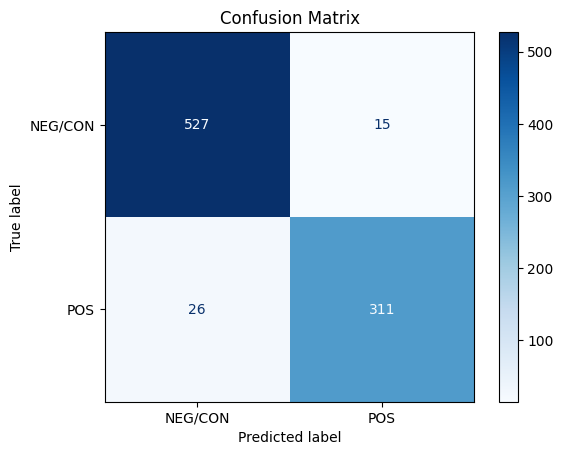

In [4]:
# Step 5: Evaluate and plot the confusion matrix
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test_labels, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["NEG/CON", "POS"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

### Step 6: Show the ROC curves (TP/FP)

Here we show the ROC, as well as two arbitrary thresholds to explore the effect of thresholds on f1/accuracy. This helps the user tune if they care more about precision or sensitivity.

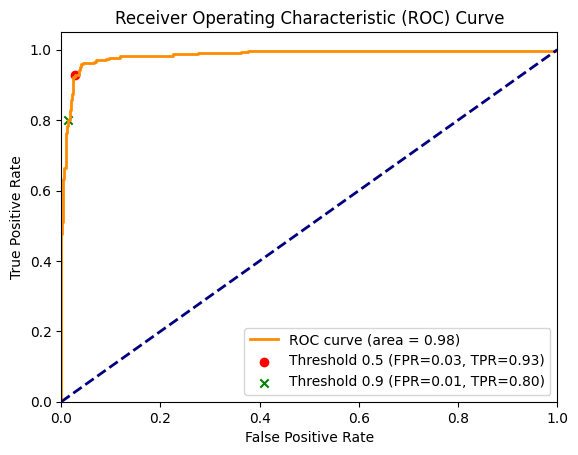

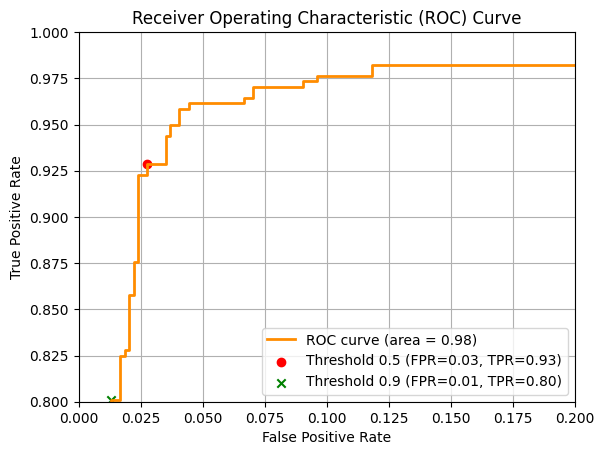

F1 Score: 0.94


In [5]:
# Step 6: Calculate and plot the ROC curve
y_prob = y_pred_prob[:, 1]  # Probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test_labels, y_prob)
roc_auc = roc_auc_score(y_test_labels, y_prob)

# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.5
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_05 = fpr[threshold_index]
tpr_05 = tpr[threshold_index]


# Find the point on the ROC curve for the threshold of 0.5
threshold = 0.9
threshold_index = np.argmin(np.abs(thresholds - threshold))
fpr_09 = fpr[threshold_index]
tpr_09 = tpr[threshold_index]

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr_05, tpr_05, color='red', marker='o', label=f'Threshold 0.5 (FPR={fpr_05:.2f}, TPR={tpr_05:.2f})')
plt.scatter(fpr_09, tpr_09, color='green', marker='x', label=f'Threshold 0.9 (FPR={fpr_09:.2f}, TPR={tpr_09:.2f})')
plt.xlim([0.0, 0.2])
plt.ylim([0.8, 1.00])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Step 7: Calculate and print the F1 score
f1 = f1_score(y_test_labels, y_pred)
print(f"F1 Score: {f1:.2f}")

# And now we can save it (we use old-style saving)
model.save(output_prefix)